I will first collect Google stock price data using the Yahoo Finance API:

In [2]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [3]:
end_date = date.today().strftime('%Y-%m-%d')
start_date = (date.today() - timedelta(days=365)).strftime('%Y-%m-%d')

data = yf.download('GOOG',
                   start=start_date,
                   end=end_date,
                   progress=False)
data['Date'] = data.index
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data.reset_index(drop=True, inplace=True)
display(data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-27,114.373001,117.500000,113.124252,115.020500,115.020500,62238000
1,2022-04-28,117.114998,120.438499,115.143898,119.411499,119.411499,36790000
2,2022-04-29,117.578003,118.959999,114.694000,114.966499,114.966499,33694000
3,2022-05-02,113.906502,117.339500,113.399498,117.156998,117.156998,30280000
4,2022-05-03,116.764999,119.300003,116.626999,118.129501,118.129501,21216000


I only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [4]:
data = data[['Date', 'Close']]
display(data.head())

,Date,Close
0,2022-04-27,115.020500
1,2022-04-28,119.411499
2,2022-04-29,114.966499
3,2022-05-02,117.156998
4,2022-05-03,118.129501


Now let’s visualize the close prices of Google before moving forward:

In [5]:
import matplotlib.pyplot as plt

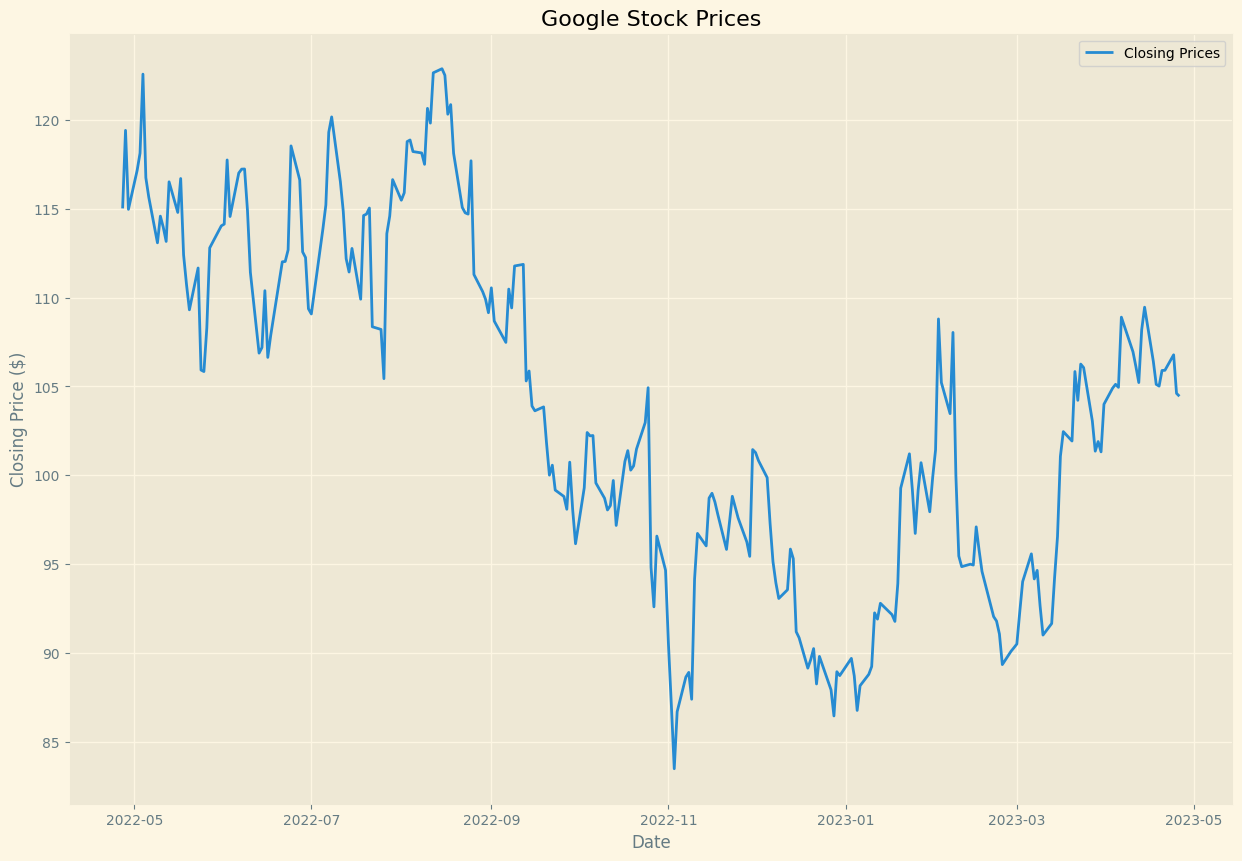

In [6]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15, 10))
plt.plot(data['Date'], data['Close'], label='Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('Google Stock Prices')
plt.legend()
plt.show()


Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the **seasonal decomposition** method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 640x480 with 0 Axes>

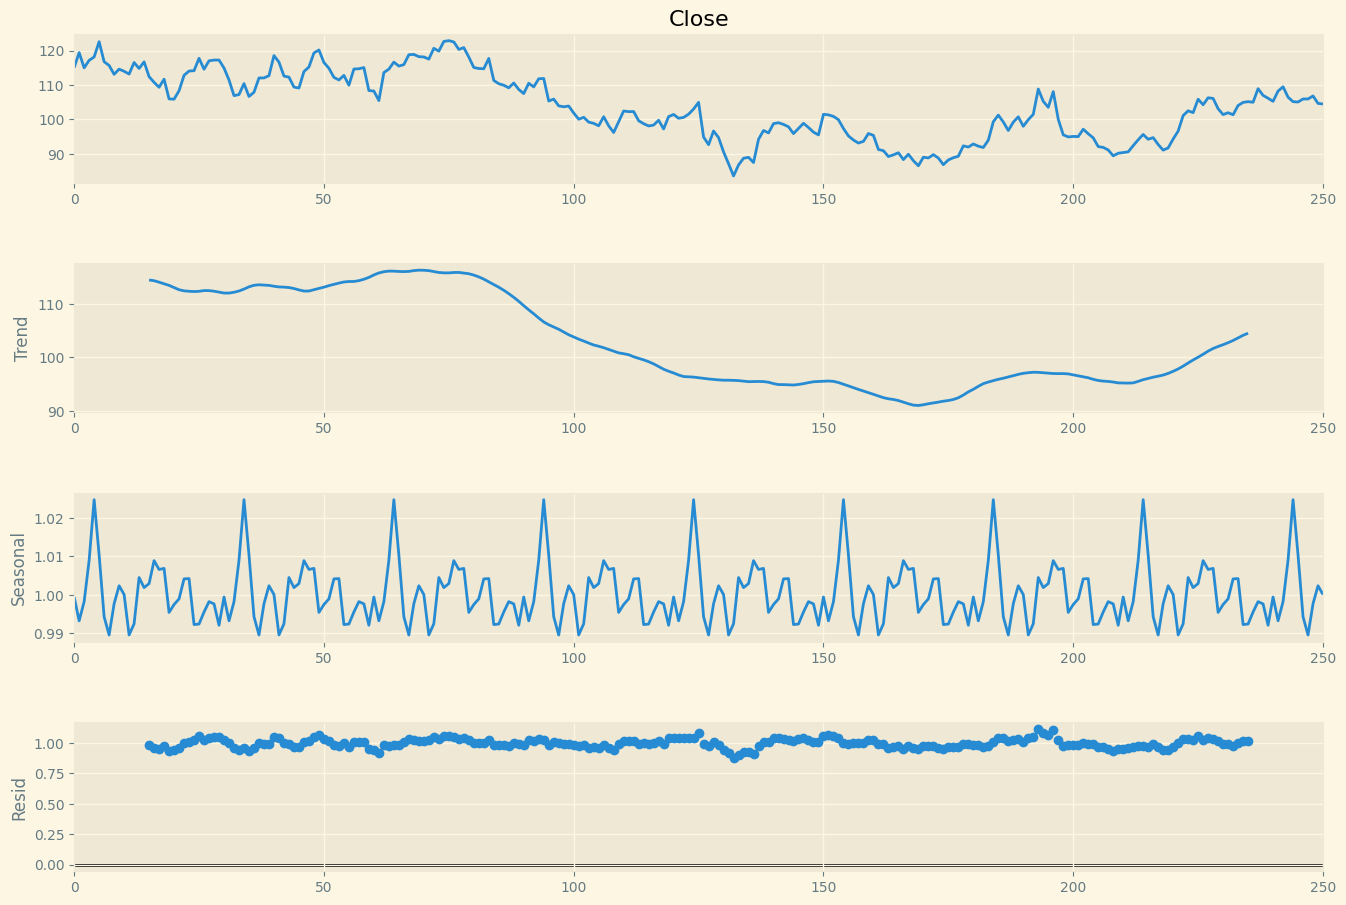

In [8]:
result = seasonal_decompose(data['Close'], 
                            model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

To determine if the time series is stationary or seasonal, we can examine the residual component of the decomposition. If the residual component appears to be random noise with a constant mean and variance, then the time series can be considered stationary. On the other hand, if the residual component exhibits a repeating pattern over time, then the time series may have a seasonal component.

So my data is not stationary it is seasonal, I need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data, but before using the SARIMA model, I will use the ARIMA model.

To use ARIMA or SARIMA, I need to find the p, d, and q values. I can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot, the value of d is either 0 or 1. If the data is stationary, I should use 0, and if the data is seasonal, I should use 1. As my data is seasonal, I should use 1 as the d value.

Now here’s how to find the value of p:

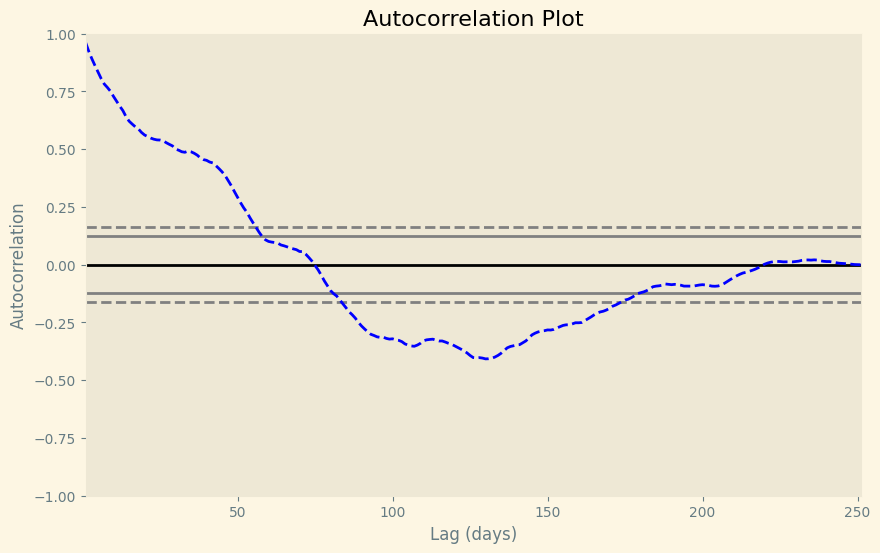

In [9]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(data['Close'], color='blue', linestyle='--')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


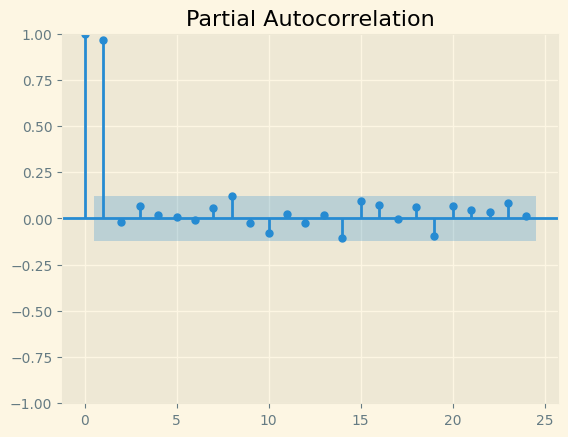

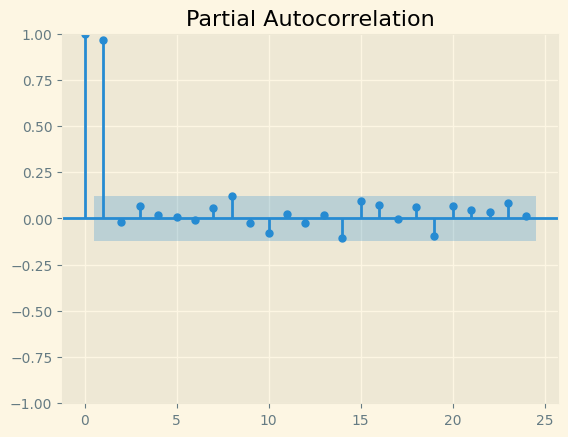

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['Close'])

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

In [11]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Close'], order=(p,d,q))
fitted_model = model.fit()
display(fitted_model.summary())

c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -588.491
Date:                Thu, 27 Apr 2023   AIC                           1192.981
Time:                        09:17:04   BIC                           1221.153
Sample:                             0   HQIC                          1204.319
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2237      1.506      0.149      0.882      -2.729       3.176
ar.L2          0.5551      1.386      0.401      0.689      -2.161       3.271
ar.L3         -0.0177      0.074     -0.239      0.811      -0.162       0.127
ar.L4          0.0270      0.066      0.407      0.684      -0.103       0.157
ar.L5         -0.0132      0.084     -0.158      0.874      -0.177       0.151
ma.L1         -0.2756      1.503     -0.183      0.854      -3.221       2.670
ma.L2         -0.6129      1.465     -0.418      0.676      -3.485       2.259
sigma2         6.4850      0.497     13.049      0.000       5.511       7.459
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.55
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we predict the values using the ARIMA model

In [12]:
predictions = fitted_model.predict()
display(predictions)

0        0.000000
1      115.020473
2      119.256557
3      114.887396
4      117.088859
          ...    
246    104.893183
247    105.710998
248    105.735687
249    106.569390
250    104.532225
Name: predicted_mean, Length: 251, dtype: float64

The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [13]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
display(model.summary())

c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -578.694
Date:                            Thu, 27 Apr 2023   AIC                           1187.388
Time:                                    09:17:21   BIC                           1239.472
Sample:                                         0   HQIC                          1208.379
                                            - 251                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.942     -0.015      0.988      -1.861       1.832
ar.L2          0.3834      0.769      0.498      0.618      -1.124       1.891
ar.L3         -0.0154      0.074     -0.207      0.836      -0.161       0.130
ar.L4         -0.0266      0.081     -0.328      0.743      -0.186       0.132
ar.L5         -0.0665      0.084     -0.796      0.426      -0.230       0.097
ma.L1         -0.0559      0.934     -0.060      0.952      -1.886       1.774
ma.L2         -0.4529      0.808     -0.560      0.575      -2.037       1.131
ar.S.L12      -0.2885      0.867     -0.333      0.739      -1.987       1.410
ar.S.L24      -0.1036      0.130     -0.799      0.424      -0.358       0.150
ar.S.L36      -0.0308      0.130     -0.237      0.813      -0.286       0.224
ar.S.L48       0.0051      0.136      0.037      0.970      -0.262       0.272
ar.S.L60      -0.1115      0.120     -0.926      0.355      -0.348       0.125
ma.S.L12      -0.7060      0.856     -0.824      0.410      -2.385       0.973
ma.S.L24      -0.1625      0.843     -0.193      0.847      -1.815       1.490
sigma2         6.8340      0.709      9.643      0.000       5.445       8.223
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.36
Prob(Q):                              0.94   Prob(JB):                         0.02
Heteroskedasticity (H):               0.69   Skew:                             0.14
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [14]:
predictions = model.predict(len(data), len(data)+10)
display(predictions)

251    103.478721
252    102.979164
253    102.522060
254    103.258544
255    103.705641
256    104.347181
257    104.800645
258    104.763305
259    104.117953
260    104.663650
261    105.616536
Name: predicted_mean, dtype: float64

Then, we plot the predictions:

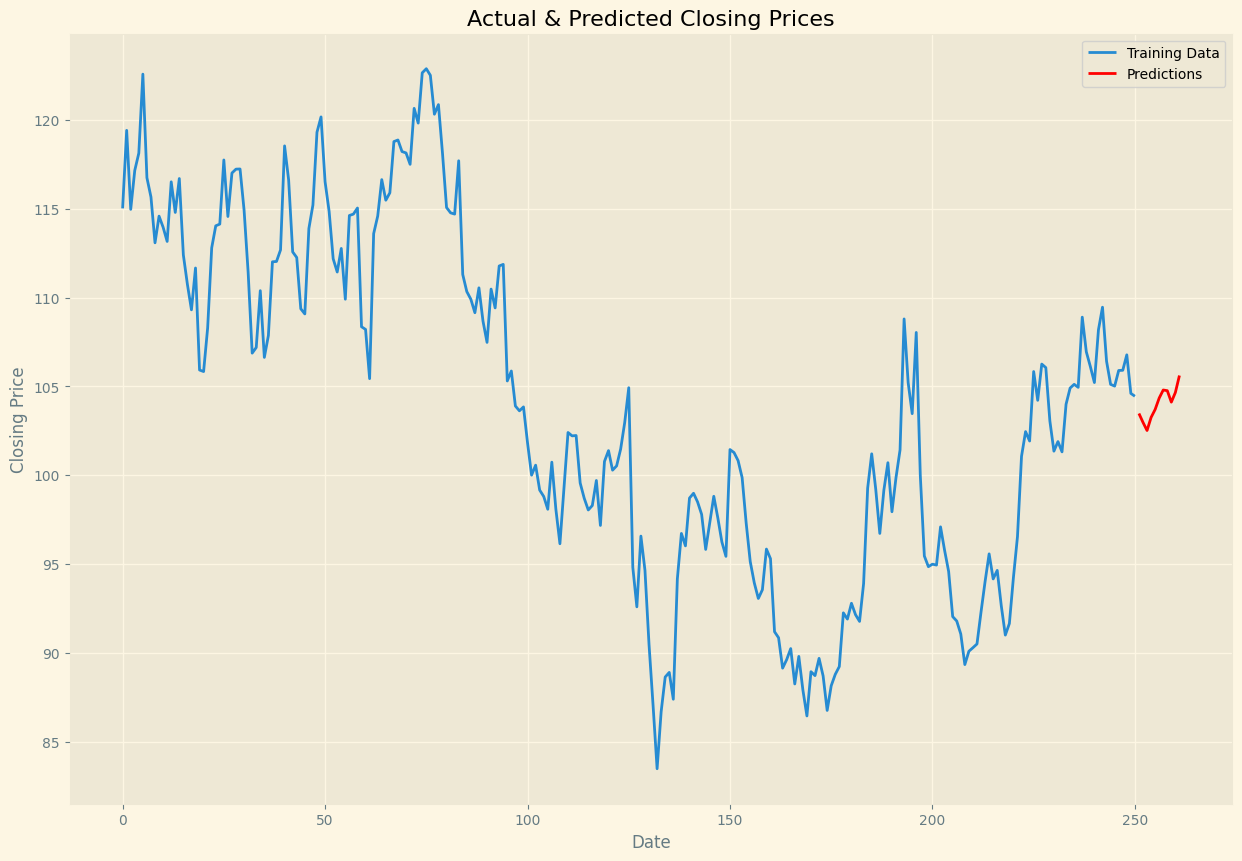

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data['Close'], label='Training Data')
ax.plot(predictions, label='Predictions', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title('Actual & Predicted Closing Prices')
ax.legend()